 # Build a Multi-output Model

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [3]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [11]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)



In [14]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.79,637.0,343.0,147.0,7.0,4,0.40,4,41.32,46.23
1,0.69,735.0,294.0,220.5,3.5,2,0.10,2,11.45,13.20
2,0.64,784.0,343.0,220.5,3.5,3,0.10,4,15.19,19.25
3,0.74,686.0,245.0,220.5,3.5,5,0.40,5,14.39,16.70
4,0.69,735.0,294.0,220.5,3.5,3,0.10,4,11.22,14.49
...,...,...,...,...,...,...,...,...,...,...
763,0.86,588.0,294.0,147.0,7.0,2,0.10,5,27.03,25.82
764,0.66,759.5,318.5,220.5,3.5,5,0.25,5,13.02,16.06
765,0.64,784.0,343.0,220.5,3.5,2,0.40,1,19.52,22.72
766,0.74,686.0,245.0,220.5,3.5,5,0.40,4,14.44,17.32


In [15]:
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [16]:
train_Y

(array([32.33 , 16.69 , 31.12 , 36.59 , 28.83 , 39.72 , 17.14 , 12.93 ,
        14.19 , 41.3  , 32.69 , 15.32 , 12.74 , 30.   , 12.63 , 23.93 ,
        16.9  , 24.77 , 14.1  , 13.02 , 28.95 , 11.69 , 16.44 , 29.08 ,
        14.71 , 40.   , 14.4  , 29.47 , 13.69 , 15.36 ,  6.37 , 11.21 ,
         6.07 , 32.73 , 14.66 , 13.17 , 16.62 , 29.68 , 17.52 , 18.84 ,
        35.45 , 41.73 , 11.33 , 22.8  , 13.99 , 11.69 , 12.18 , 36.43 ,
        16.92 , 28.62 , 36.81 , 32.52 , 18.48 , 29.08 , 12.35 , 23.67 ,
        32.31 , 15.12 , 15.16 , 16.74 , 24.58 , 36.45 , 14.16 , 36.26 ,
        12.49 , 23.53 , 24.6  , 12.02 , 40.12 , 10.39 , 24.37 , 32.39 ,
         6.04 , 28.18 , 32.33 , 36.95 ,  6.05 , 38.67 , 33.21 , 16.73 ,
        26.45 , 38.57 , 24.23 , 32.49 , 29.07 , 11.68 , 10.68 , 25.38 ,
        23.86 , 14.58 , 40.68 , 16.93 , 11.61 , 25.74 , 29.27 , 15.55 ,
        29.06 , 35.96 , 29.39 , 29.06 , 28.42 , 12.95 , 32.21 , 25.27 ,
        28.91 , 33.08 , 26.91 , 16.48 , 11.16 , 27.27 , 39.83 , 

## Build the Model 1

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

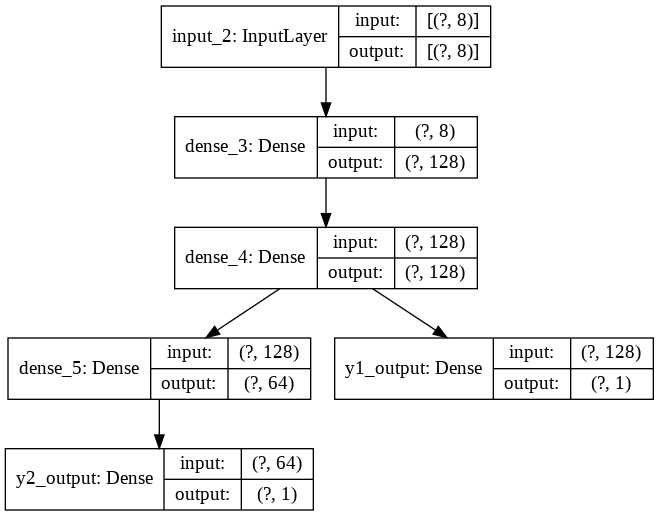

In [18]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [19]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

In [20]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 941us/sample - loss: 226.7803 - y1_output_loss: 108.1732 - y2_output_loss: 116.8550 - y1_output_root_mean_squared_error: 10.4349 - y2_output_root_mean_squared_error: 10.8579 - val_loss: 34.9860 - val_y1_output_loss: 14.8673 - val_y2_output_loss: 20.7735 - val_y1_output_root_mean_squared_error: 3.8345 - val_y2_output_root_mean_squared_error: 4.5036
Epoch 2/500
614/614 [==============================] - 0s 162us/sample - loss: 33.1871 - y1_output_loss: 12.2092 - y2_output_loss: 20.7528 - y1_output_root_mean_squared_error: 3.5083 - y2_output_root_mean_squared_error: 4.5694 - val_loss: 33.3648 - val_y1_output_loss: 14.2210 - val_y2_output_loss: 19.9903 - val_y1_output_root_mean_squared_error: 3.7213 - val_y2_output_root_mean_squared_error: 4.4178
Epoch 3/500
614/614 [==============================] - 0s 142us/sample - loss: 26.8879 - y1_output_loss: 10.0624 - y2_output_loss: 16.8747 - y1

# Build Model2 - with two output units ( no branch)

### Previous models y values was (y1,y2) tuples where it will be converted to [y1,y2] single array -> y_new

In [40]:
print(f"len y values was : {len(train_Y)}")
print(f"len y1 shape : {(train_Y[0].shape)}")

len y values was : 2
len y1 shape : (614,)


In [45]:
y_new = np.array([*train_Y])
y_new.shape

(2, 614)

In [46]:
y_new = y_new.T
y_new.shape

(614, 2)

In [50]:
y_new_test = np.array([*test_Y]).T
y_new_test.shape

(154, 2)

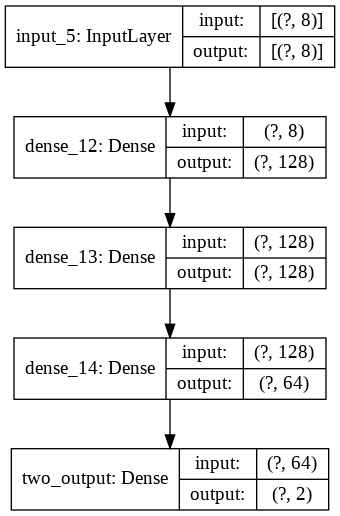

In [47]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
output = Dense(units='2', name='two_output')(third_dense)

# Define the model with the input layer and a list of output layers
model2 = Model(inputs=input_layer, outputs=output)

from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model2, show_shapes=True, show_layer_names=True)

In [51]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model2.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [52]:
# Train the model for 500 epochs
history = model2.fit(norm_train_X, y_new,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, y_new_test))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 0s 541us/sample - loss: 142.2694 - root_mean_squared_error: 11.9277 - val_loss: 19.3067 - val_root_mean_squared_error: 4.3939
Epoch 2/500
614/614 [==============================] - 0s 123us/sample - loss: 14.1588 - root_mean_squared_error: 3.7628 - val_loss: 17.7863 - val_root_mean_squared_error: 4.2174
Epoch 3/500
614/614 [==============================] - 0s 113us/sample - loss: 12.1174 - root_mean_squared_error: 3.4810 - val_loss: 14.1978 - val_root_mean_squared_error: 3.7680
Epoch 4/500
614/614 [==============================] - 0s 126us/sample - loss: 10.3445 - root_mean_squared_error: 3.2163 - val_loss: 15.7149 - val_root_mean_squared_error: 3.9642
Epoch 5/500
614/614 [==============================] - 0s 127us/sample - loss: 10.0984 - root_mean_squared_error: 3.1778 - val_loss: 12.2167 - val_root_mean_squared_error: 3.4952
Epoch 6/500
614/614 [==============================] - 0s

## Evaluate the Model and Plot Metrics

In [21]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 35us/sample - loss: 0.7686 - y1_output_loss: 0.1916 - y2_output_loss: 0.5795 - y1_output_root_mean_squared_error: 0.4394 - y2_output_root_mean_squared_error: 0.7586
Loss = 0.7686039735744525, Y1_loss = 0.19163507223129272, Y1_mse = 0.4394143521785736, Y2_loss = 0.5794938802719116, Y2_mse = 0.7586296796798706


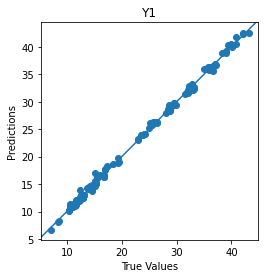

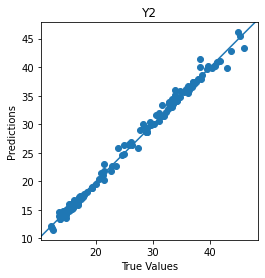

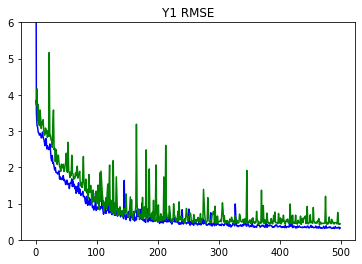

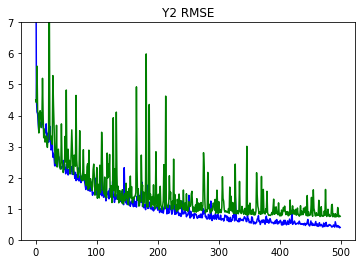

In [22]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)